<a href="https://colab.research.google.com/github/tommycwong/ensemble_TEM/blob/master/TEM_Helium_Bubbles_Ensemble_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Generate baseline IoUs

Install atomai and import modules:

In [ ]:
!pip install atomai

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import gdown

Define functions for loading in images and calculating IoUs:

In [ ]:
"""model_unet = !gdown https://drive.google.com/uc?id=1-4Lhc8boy8wHDjzBi28nwcaQzwP0zkwZ
model_baseline_unet = !gdown https://drive.google.com/uc?id=1-0_qVoVWjXV3lQBVZnLQsZlOQjWHvT8m
model_dilnet = !gdown https://drive.google.com/uc?id=1-8t2xiArvgPLsyouEzHsClNOLkSyWart
model_baseline_dilnet = !gdown https://drive.google.com/uc?id=1aLxGeDEImRDTnKT2gOEhDHiHWNK7S2L9"""

In [ ]:
def loader(architecture):
    test_labels = np.load("/content/drive/Shared drives/NESLS/TEM_Helium_Bubbles_[Proper]/Data/Accuracy validation data/Accuracy_Labels_sum.npy")
    test_imgs = np.load("/content/drive/Shared drives/NESLS/TEM_Helium_Bubbles_[Proper]/Data/Accuracy validation data/Original_Images.npy")
    test_labels = test_labels.transpose([-1, 0, 1])
    test_imgs = test_imgs.transpose([-1, 0, 1])
    test_labels[test_labels > 0] = 1

    if architecture == 'unet':
        smodel, ensemble = aoi.load_ensemble("/content/drive/Shared drives/NESLS/TEM_HeliumBubbles/Trained_torch/bubbles_unet_bnorm_swa_from_scratch_1_ensemble.tar")
        #smodel, ensemble = aoi.load_ensemble(model_unet)
        smodel_avg, ensemble_avg = aoi.load_ensemble("/content/drive/Shared drives/NESLS/TEM_HeliumBubbles/Trained_torch/bubbles_unet_from_baseline_1_ensemble.tar")
        #smodel_avg, ensemble_avg = aoi.load_ensemble(model_baseline_unet)
    else:
        smodel, ensemble = aoi.load_ensemble("/content/drive/Shared drives/NESLS/TEM_HeliumBubbles/Trained_torch/bubbles_dilnet_bnorm_swa_from_scratch_1_ensemble.tar")
        #smodel, ensemble = aoi.load_ensemble(model_dilnet)
        smodel_avg, ensemble_avg = aoi.load_ensemble("/content/drive/Shared drives/NESLS/TEM_HeliumBubbles/Trained_torch/bubbles_from_baseline_1_ensemble.tar")
        #smodel_avg, ensemble_avg = aoi.load_ensemble(model_baseline_dilnet)

    return test_imgs, test_labels, smodel, ensemble, smodel_avg, ensemble_avg

In [ ]:
def iou_calc(test_img, test_label, s_model, s_ensemble, s_model_avg, s_ensemble_avg):
    tor = lambda x: torch.from_numpy(x.transpose(0,-1, 1, 2) if x.ndim ==4 else x)

    single_iou = []
    for i, m in s_ensemble.items():
        s_model.load_state_dict(m)
        spred = aoi.atomnet.predictor(s_model, use_gpu=True, verbose=False).run(test_img)[0]
        iou = aoi.losses_metrics.IoU(tor(test_label), tor(spred), activation=False)
        single_iou.append(iou.evaluate())
        #print("Single model {}:".format(i), iou.evaluate())

    epred, evar = aoi.atomnet.ensemble_predictor(s_model, s_ensemble, use_gpu=True, verbose=False).run(test_img)[0] # ensemble labels
    iou = aoi.losses_metrics.IoU(tor(test_label), tor(epred), activation=False)
    #print("\nEnsemble IoU score:", iou.evaluate())
    ensemble_iou = iou.evaluate()

    s_model_avg.load_state_dict(aoi.utils.average_weights(s_ensemble_avg))
    apred = aoi.atomnet.predictor(s_model_avg, use_gpu=True, verbose=False).run(test_img)[0] # average labels
    iou = aoi.losses_metrics.IoU(tor(test_label), tor(apred), activation=False)
    #print("Average weights", iou.evaluate())
    weights_aver_iou = iou.evaluate()

    return single_iou, weights_aver_iou, ensemble_iou

Load images and generate IoUs for baseline cases:

In [ ]:
# load images
test_imgs_d, test_labels_d, smodel_d, ensemble_d, smodel_avg_d, ensemble_avg_d = loader('dilnet')
test_imgs_u, test_labels_u, smodel_u, ensemble_u, smodel_avg_u, ensemble_avg_u = loader('unet')

In [ ]:
# calculate IoUs
single_iou_d, weights_aver_iou_d, ensemble_iou_d = iou_calc(test_imgs_d, test_labels_d, smodel_d, ensemble_d, smodel_avg_d, ensemble_avg_d)
single_iou_u, weights_aver_iou_u, ensemble_iou_u = iou_calc(test_imgs_u, test_labels_u, smodel_u, ensemble_u, smodel_avg_u, ensemble_avg_u)

print(ensemble_iou_u, ensemble_iou_d)
print(weights_aver_iou_u, weights_aver_iou_d)

/usr/local/lib/python3.6/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 1/10.8673156499862671 0.849098801612854
0.8504467606544495 0.8438632488250732


Text(0.5, 1.0, 'unet (from_baseline)')

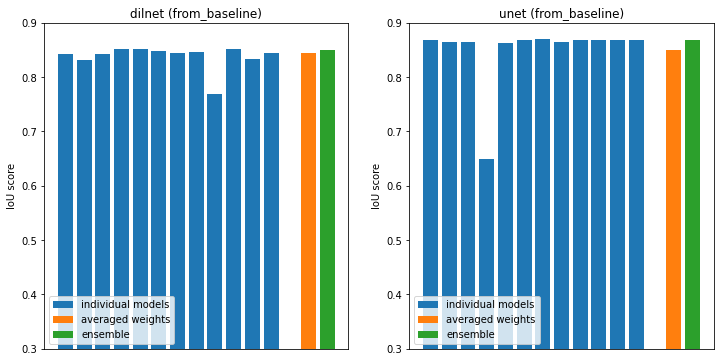

In [ ]:
# plot IoUs
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(np.arange(len(single_iou_d)), single_iou_d, label='individual models')
axs[0].bar(len(single_iou_d) + 1, weights_aver_iou_d, label="averaged weights")
axs[0].bar(len(single_iou_d) + 2, ensemble_iou_d, label="ensemble")
axs[0].set_ylabel("IoU score")
axs[0].set_xticks([])
axs[0].set_ylim(0.3, .9)
axs[0].legend(loc=3)
axs[0].set_title("dilnet (from_baseline)")

axs[1].bar(np.arange(len(single_iou_u)), single_iou_u, label='individual models')
axs[1].bar(len(single_iou_u) + 1, weights_aver_iou_u, label="averaged weights")
axs[1].bar(len(single_iou_u) + 2, ensemble_iou_u, label="ensemble")
axs[1].set_ylabel("IoU score")
axs[1].set_xticks([])
axs[1].set_ylim(0.3, .9)
axs[1].legend(loc=3)
axs[1].set_title("unet (from_baseline)")

## Generate trends for IoU

Add noise:

In [ ]:
def add_noise(i, test_img, test_label, noise_type):
    if noise_type == 'blur':
        test_img, test_label = aoi.transforms.datatransform(1, blur=[i, i+1]).run(test_img, test_label[..., None])
    elif noise_type == 'gauss_noise':
        test_img, test_label = aoi.transforms.datatransform(1, gauss_noise=[i, i+1]).run(test_img, test_label[..., None])
    else:
        test_img, test_label = aoi.transforms.datatransform(1, salt_and_pepper=[i, i+1]).run(test_img, test_label[..., None])
    test_img = test_img[:,0,...]
    test_label = test_label[:,0,...]

    return test_img, test_label

Show examples of the noise added:

In [ ]:
# dilnet
test_imgs_d, test_labels_d, smodel_d, ensemble_d, smodel_avg_d, ensemble_avg_d = loader('dilnet')
img_blur_d, label_blur_d = add_noise(100, test_imgs_d, test_labels_d, 'blur')
epred_blur_d, evar_blur_d = aoi.atomnet.ensemble_predictor(smodel_d, ensemble_d, use_gpu=True, verbose=False).run(img_blur_d)[0]
test_imgs_d, test_labels_d, smodel_d, ensemble_d, smodel_avg_d, ensemble_avg_d = loader('dilnet')
img_gauss_d, label_gauss_d = add_noise(100, test_imgs_d, test_labels_d, 'gauss_noise')
epred_gauss_d, evar_gauss_d = aoi.atomnet.ensemble_predictor(smodel_d, ensemble_d, use_gpu=True, verbose=False).run(img_gauss_d)[0]
test_imgs_d, test_labels_d, smodel_d, ensemble_d, smodel_avg_d, ensemble_avg_d = loader('dilnet')
img_snp_d, label_snp_d = add_noise(30, test_imgs_d, test_labels_d, 'salt_and_pepper')
epred_snp_d, evar_snp_d = aoi.atomnet.ensemble_predictor(smodel_d, ensemble_d, use_gpu=True, verbose=False).run(img_snp_d)[0]

# unet
test_imgs_u, test_labels_u, smodel_u, ensemble_u, smodel_avg_u, ensemble_avg_u = loader('unet')
img_blur_u, label_blur_u = add_noise(100, test_imgs_u, test_labels_u, 'blur')
epred_blur_u, evar_blur_u = aoi.atomnet.ensemble_predictor(smodel_u, ensemble_u, use_gpu=True, verbose=False).run(img_blur_u)[0]
test_imgs_u, test_labels_u, smodel_u, ensemble_u, smodel_avg_u, ensemble_avg_u = loader('unet')
img_gauss_u, label_gauss_u = add_noise(100, test_imgs_u, test_labels_u, 'gauss_noise')
epred_gauss_u, evar_gauss_u = aoi.atomnet.ensemble_predictor(smodel_u, ensemble_u, use_gpu=True, verbose=False).run(img_gauss_u)[0]
test_imgs_u, test_labels_u, smodel_u, ensemble_u, smodel_avg_u, ensemble_avg_u = loader('unet')
img_snp_u, label_snp_u = add_noise(30, test_imgs_u, test_labels_u, 'salt_and_pepper')
epred_snp_u, evar_snp_u = aoi.atomnet.ensemble_predictor(smodel_u, ensemble_u, use_gpu=True, verbose=False).run(img_snp_u)[0]

Batch 1/1

/usr/local/lib/python3.6/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 1/1

Text(0, 0.5, 'unet')

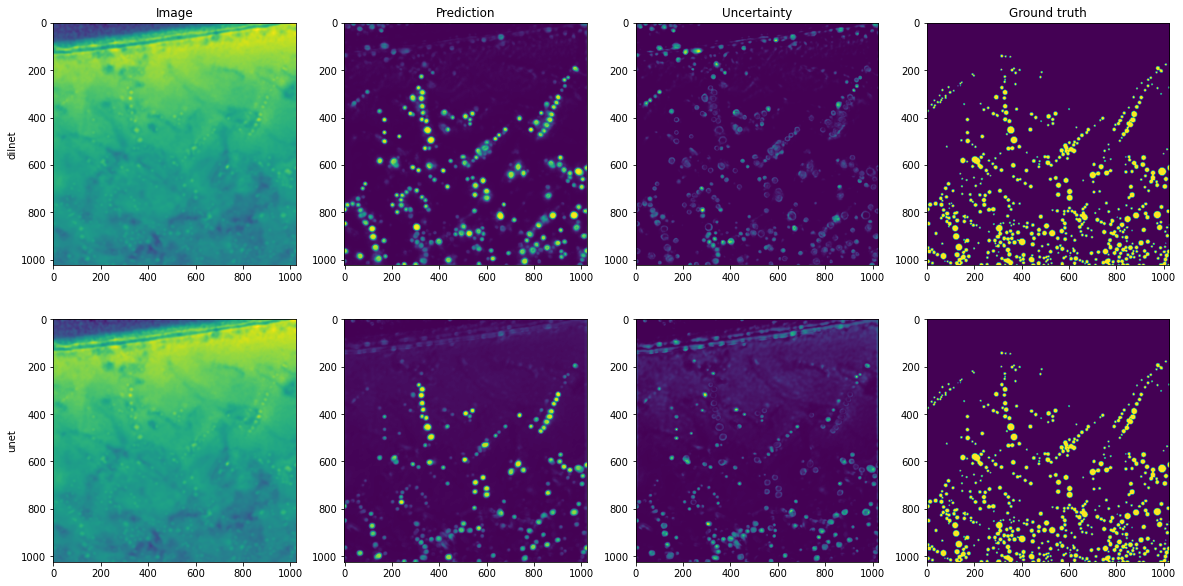

In [ ]:
# Blur
k = 0
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0,0].imshow(img_blur_d[k])
axs[0,1].imshow(epred_blur_d[k, ..., 0])
axs[0,2].imshow(evar_blur_d[k,...,0])
axs[0,3].imshow(label_blur_d[k])
axs[1,0].imshow(img_blur_u[k])
axs[1,1].imshow(epred_blur_u[k, ..., 0])
axs[1,2].imshow(evar_blur_u[k,...,0])
axs[1,3].imshow(label_blur_u[k])
axs[0,0].set_title("Image")
axs[0,1].set_title("Prediction")
axs[0,2].set_title("Uncertainty")
axs[0,3].set_title("Ground truth")
axs[0,0].set_ylabel("dilnet")
axs[1,0].set_ylabel("unet")

Text(0, 0.5, 'unet')

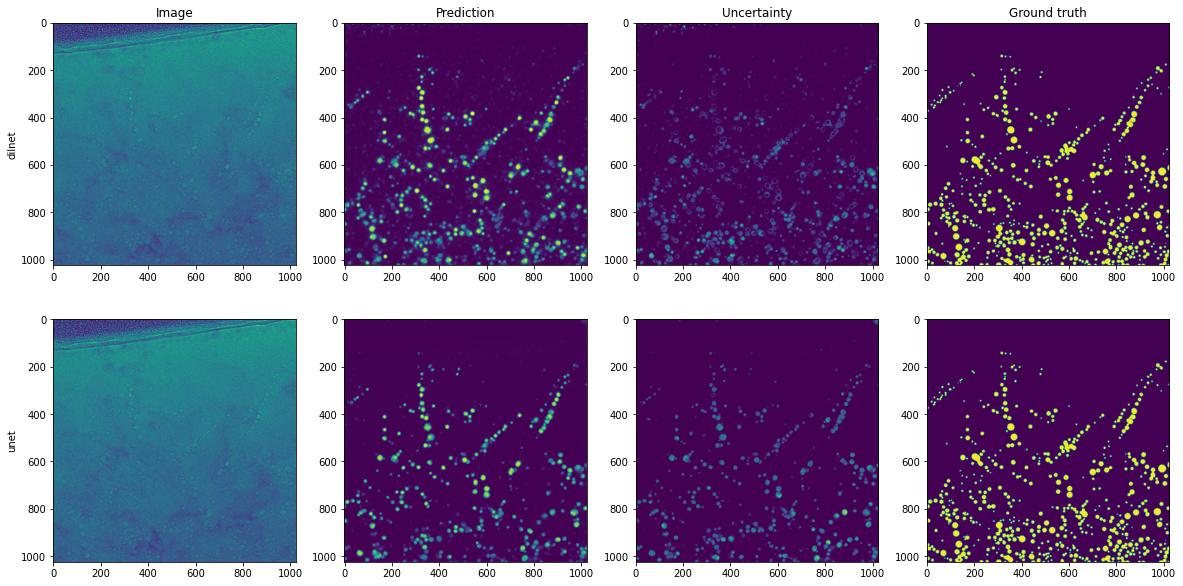

In [ ]:
# Gaussian noise
k = 0
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0,0].imshow(img_gauss_d[k])
axs[0,1].imshow(epred_gauss_d[k, ..., 0])
axs[0,2].imshow(evar_gauss_d[k,...,0])
axs[0,3].imshow(label_gauss_d[k])
axs[1,0].imshow(img_gauss_u[k])
axs[1,1].imshow(epred_gauss_u[k, ..., 0])
axs[1,2].imshow(evar_gauss_u[k,...,0])
axs[1,3].imshow(label_gauss_u[k])
axs[0,0].set_title("Image")
axs[0,1].set_title("Prediction")
axs[0,2].set_title("Uncertainty")
axs[0,3].set_title("Ground truth")
axs[0,0].set_ylabel("dilnet")
axs[1,0].set_ylabel("unet")

Text(0, 0.5, 'unet')

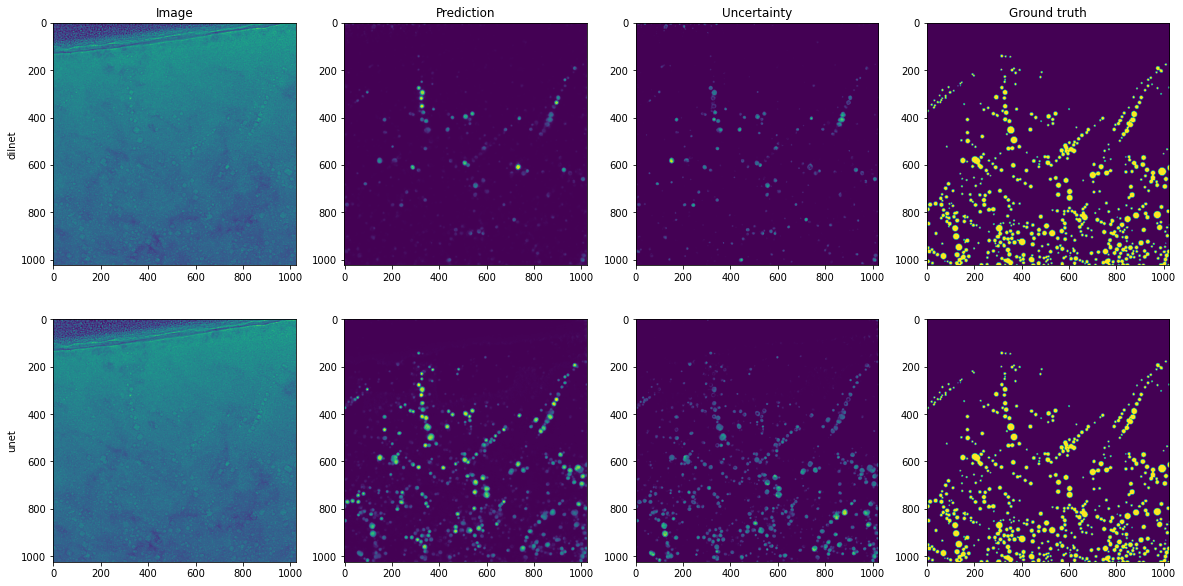

In [ ]:
# Salt & Pepper
k = 0
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0,0].imshow(img_snp_d[k])
axs[0,1].imshow(epred_snp_d[k, ..., 0])
axs[0,2].imshow(evar_snp_d[k,...,0])
axs[0,3].imshow(label_snp_d[k])
axs[1,0].imshow(img_snp_u[k])
axs[1,1].imshow(epred_snp_u[k, ..., 0])
axs[1,2].imshow(evar_snp_u[k,...,0])
axs[1,3].imshow(label_snp_u[k])
axs[0,0].set_title("Image")
axs[0,1].set_title("Prediction")
axs[0,2].set_title("Uncertainty")
axs[0,3].set_title("Ground truth")
axs[0,0].set_ylabel("dilnet")
axs[1,0].set_ylabel("unet")

Compute IoUs over a range of noise levels for different noises and DNN models:

In [ ]:
"""!rmmod nvidia
!modprobe nvidia"""

rmmod: ERROR: Module nvidia is in use by: nvidia_uvm
modprobe: FATAL: Module nvidia not found in directory /lib/modules/4.19.112+


In [ ]:
noise_range = np.arange(0, 201, 5)
#ious = np.zeros((3, len(noise_range), len(single_iou_u), 2))
ious = np.zeros((3, len(noise_range), 12, 2))
single_best_ious = np.zeros((3, len(noise_range), 2))
single_worst_ious = np.zeros((3, len(noise_range), 2))
weights_aver_ious = np.zeros((3, len(noise_range), 2))
ensemble_ious = np.zeros((3, len(noise_range), 2))

for k in range(len(('dilnet', 'unet'))):
    test_imgs, test_labels, smodel, ensemble, smodel_avg, ensemble_avg = loader(('dilnet', 'unet')[k])
    iou_nonoise, avg_iou_nonoise, ens_iou_nonoise = iou_calc(test_imgs, test_labels, smodel, ensemble, smodel_avg, ensemble_avg)
    best = np.argmax(iou_nonoise)
    worst = np.argmin(iou_nonoise)
    #print('selected {}'.format(('dilnet', 'unet')[k]))
    for i in range(len(('blur', 'gauss_noise', 'salt_and_pepper'))):
        #print('selected {}'.format(('blur', 'gauss_noise', 'salt_and_pepper')[i]))
        for j in range(len(noise_range)):
            img, label = add_noise(noise_range[j], test_imgs, test_labels, ('blur', 'gauss_noise', 'salt_and_pepper')[i])
            single_iou, weights_aver_iou, ensemble_iou = iou_calc(img, label, smodel, ensemble, smodel_avg, ensemble_avg)
            ious[i, j, :, k] = single_iou
            single_best_ious[i, j, k] = single_iou[best]
            single_worst_ious[i, j, k] = single_iou[worst]
            weights_aver_ious[i, j, k] = weights_aver_iou
            ensemble_ious[i, j, k] = ensemble_iou
            #print('evaluated enssemble iou {}: {}'.format(j, ensemble_ious[i, j, k]))

/usr/local/lib/python3.6/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 1/1

Save the IoUs as an ```.npz``` file:

In [ ]:
os.chdir('/content/drive/Shared drives/Bredesen Center ESE PhD/TEM_bubbles_ensemble')
np.savez('enssemble_IoU_v2a', noise_range=noise_range,
         ious=ious, single_best_ious=single_best_ious,
         single_worst_ious=single_worst_ious, weights_aver_ious=weights_aver_ious,
         ensemble_ious=ensemble_ious)

Load IoUs and plot trends:

In [ ]:
data = np.load('/content/drive/Shared drives/Bredesen Center ESE PhD/TEM_bubbles_ensemble/enssemble_IoU_v2a.npz')

In [ ]:
noise_range = data['noise_range']; ious = data['ious']; single_best_ious = data['single_best_ious']
single_worst_ious = data['single_worst_ious']; weights_aver_ious = data['weights_aver_ious']
ensemble_ious = data['ensemble_ious']

Text(0.5, 1.0, 'unet S&P noise=[30, 31]')

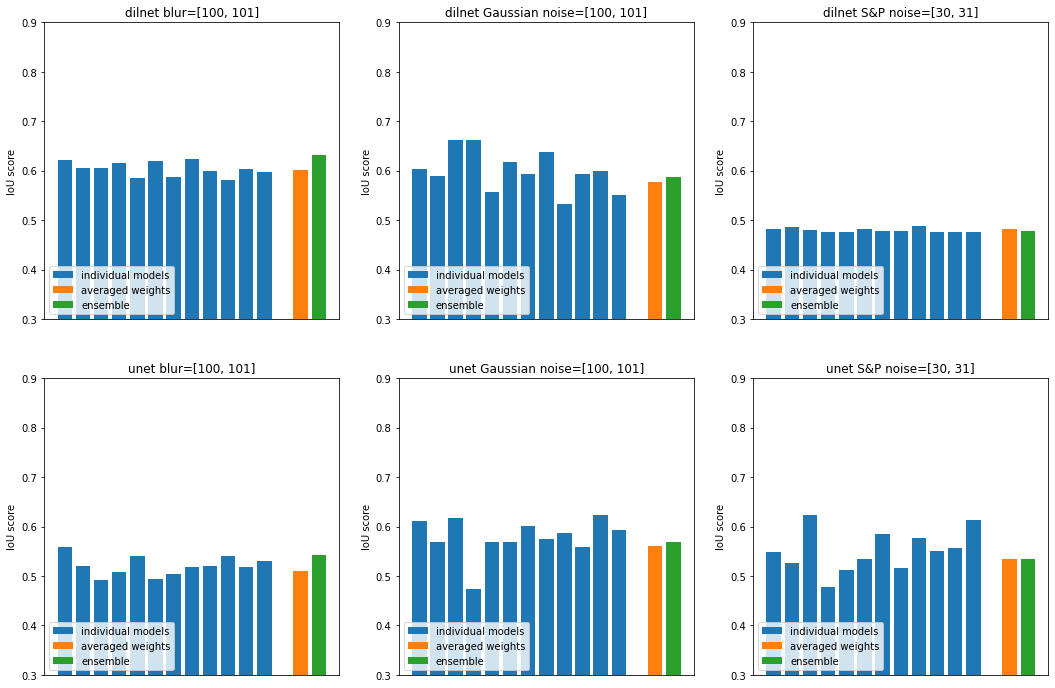

In [ ]:
# plot IoU histograms
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# dilnet
axs[0,0].bar(np.arange(len(ious[0, 20, :, 0])), ious[0, 20, :, 0], label='individual models')
axs[0,0].bar(len(ious[0, 20, :, 0]) + 1, weights_aver_ious[0, 20, 0], label="averaged weights")
axs[0,0].bar(len(ious[0, 20, :, 0]) + 2, ensemble_ious[0, 20, 0], label="ensemble")
axs[0,0].set_ylabel("IoU score")
axs[0,0].set_xticks([])
axs[0,0].set_ylim(0.3, .9)
axs[0,0].legend(loc=3)
axs[0,0].set_title("dilnet blur=[100, 101]")

axs[0,1].bar(np.arange(len(ious[1, 20, :, 0])), ious[1, 20, :, 0], label='individual models')
axs[0,1].bar(len(ious[1, 20, :, 0]) + 1, weights_aver_ious[1, 20, 0], label="averaged weights")
axs[0,1].bar(len(ious[1, 20, :, 0]) + 2, ensemble_ious[1, 20, 0], label="ensemble")
axs[0,1].set_ylabel("IoU score")
axs[0,1].set_xticks([])
axs[0,1].set_ylim(0.3, .9)
axs[0,1].legend(loc=3)
axs[0,1].set_title("dilnet Gaussian noise=[100, 101]")

axs[0,2].bar(np.arange(len(ious[2, 6, :, 0])), ious[2, 6, :, 0], label='individual models')
axs[0,2].bar(len(ious[2, 6, :, 0]) + 1, weights_aver_ious[2, 6, 0], label="averaged weights")
axs[0,2].bar(len(ious[2, 6, :, 0]) + 2, ensemble_ious[2, 6, 0], label="ensemble")
axs[0,2].set_ylabel("IoU score")
axs[0,2].set_xticks([])
axs[0,2].set_ylim(0.3, .9)
axs[0,2].legend(loc=3)
axs[0,2].set_title("dilnet S&P noise=[30, 31]")

# unet
axs[1,0].bar(np.arange(len(ious[0, 20, :, 1])), ious[0, 20, :, 1], label='individual models')
axs[1,0].bar(len(ious[0, 20, :, 1]) + 1, weights_aver_ious[0, 20, 1], label="averaged weights")
axs[1,0].bar(len(ious[0, 20, :, 1]) + 2, ensemble_ious[0, 20, 1], label="ensemble")
axs[1,0].set_ylabel("IoU score")
axs[1,0].set_xticks([])
axs[1,0].set_ylim(0.3, .9)
axs[1,0].legend(loc=3)
axs[1,0].set_title("unet blur=[100, 101]")

axs[1,1].bar(np.arange(len(ious[1, 20, :, 1])), ious[1, 20, :, 1], label='individual models')
axs[1,1].bar(len(ious[1, 20, :, 1]) + 1, weights_aver_ious[1, 20, 1], label="averaged weights")
axs[1,1].bar(len(ious[1, 20, :, 1]) + 2, ensemble_ious[1, 20, 1], label="ensemble")
axs[1,1].set_ylabel("IoU score")
axs[1,1].set_xticks([])
axs[1,1].set_ylim(0.3, .9)
axs[1,1].legend(loc=3)
axs[1,1].set_title("unet Gaussian noise=[100, 101]")

axs[1,2].bar(np.arange(len(ious[2, 6, :, 1])), ious[2, 6, :, 1], label='individual models')
axs[1,2].bar(len(ious[2, 6, :, 1]) + 1, weights_aver_ious[2, 6, 1], label="averaged weights")
axs[1,2].bar(len(ious[2, 6, :, 1]) + 2, ensemble_ious[2, 6, 1], label="ensemble")
axs[1,2].set_ylabel("IoU score")
axs[1,2].set_xticks([])
axs[1,2].set_ylim(0.3, .9)
axs[1,2].legend(loc=3)
axs[1,2].set_title("unet S&P noise=[30, 31]")

Text(0.5, 1.0, 'avg & ensemble IoU S&P')

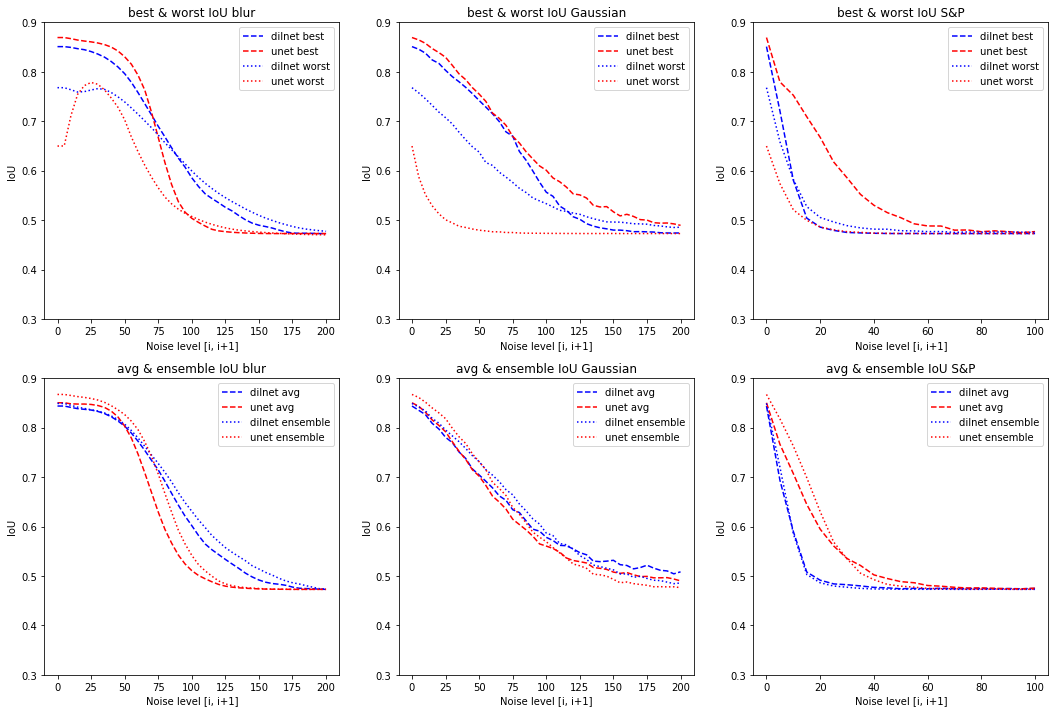

In [ ]:
# Plot IoU trends
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Best and worst performing single models
axs[0,0].plot(noise_range, single_best_ious[0, :, 0], 'b--', label='dilnet best')
axs[0,0].plot(noise_range, single_best_ious[0, :, 1], 'r--', label="unet best")
axs[0,0].plot(noise_range, single_worst_ious[0, :, 0], 'b:', label='dilnet worst')
axs[0,0].plot(noise_range, single_worst_ious[0, :, 1], 'r:', label="unet worst")
axs[0,0].set_xlabel('Noise level [i, i+1]'); axs[0,0].set_ylabel("IoU")
axs[0,0].set_ylim(0.3, .9)
axs[0,0].legend()
axs[0,0].set_title("best & worst IoU blur")

axs[0,1].plot(noise_range, single_best_ious[1, :, 0], 'b--', label='dilnet best')
axs[0,1].plot(noise_range, single_best_ious[1, :, 1], 'r--', label="unet best")
axs[0,1].plot(noise_range, single_worst_ious[1, :, 0], 'b:', label='dilnet worst')
axs[0,1].plot(noise_range, single_worst_ious[1, :, 1], 'r:', label="unet worst")
axs[0,1].set_xlabel('Noise level [i, i+1]'); axs[0,1].set_ylabel("IoU")
axs[0,1].set_ylim(0.3, .9)
axs[0,1].legend()
axs[0,1].set_title("best & worst IoU Gaussian")

axs[0,2].plot(noise_range[0 : 21], single_best_ious[2, 0 : 21, 0], 'b--', label='dilnet best')
axs[0,2].plot(noise_range[0 : 21], single_best_ious[2, 0 : 21, 1], 'r--', label="unet best")
axs[0,2].plot(noise_range[0 : 21], single_worst_ious[2, 0 : 21, 0], 'b:', label='dilnet worst')
axs[0,2].plot(noise_range[0 : 21], single_worst_ious[2, 0 : 21, 1], 'r:', label="unet worst")
axs[0,2].set_xlabel('Noise level [i, i+1]'); axs[0,2].set_ylabel("IoU")
axs[0,2].set_ylim(0.3, .9)
axs[0,2].legend()
axs[0,2].set_title("best & worst IoU S&P")

# Average weights and ensemble performance
axs[1,0].plot(noise_range, weights_aver_ious[0, :, 0], 'b--', label='dilnet avg')
axs[1,0].plot(noise_range, weights_aver_ious[0, :, 1], 'r--', label="unet avg")
axs[1,0].plot(noise_range, ensemble_ious[0, :, 0], 'b:', label='dilnet ensemble')
axs[1,0].plot(noise_range, ensemble_ious[0, :, 1], 'r:', label="unet ensemble")
axs[1,0].set_xlabel('Noise level [i, i+1]'); axs[1,0].set_ylabel("IoU")
axs[1,0].set_ylim(0.3, .9)
axs[1,0].legend()
axs[1,0].set_title("avg & ensemble IoU blur")

axs[1,1].plot(noise_range, weights_aver_ious[1, :, 0], 'b--', label='dilnet avg')
axs[1,1].plot(noise_range, weights_aver_ious[1, :, 1], 'r--', label="unet avg")
axs[1,1].plot(noise_range, ensemble_ious[1, :, 0], 'b:', label='dilnet ensemble')
axs[1,1].plot(noise_range, ensemble_ious[1, :, 1], 'r:', label="unet ensemble")
axs[1,1].set_xlabel('Noise level [i, i+1]'); axs[1,1].set_ylabel("IoU")
axs[1,1].set_ylim(0.3, .9)
axs[1,1].legend()
axs[1,1].set_title("avg & ensemble IoU Gaussian")

axs[1,2].plot(noise_range[0 : 21], weights_aver_ious[2, 0 : 21, 0], 'b--', label='dilnet avg')
axs[1,2].plot(noise_range[0 : 21], weights_aver_ious[2, 0 : 21, 1], 'r--', label="unet avg")
axs[1,2].plot(noise_range[0 : 21], ensemble_ious[2, 0 : 21, 0], 'b:', label='dilnet ensemble')
axs[1,2].plot(noise_range[0 : 21], ensemble_ious[2, 0 : 21, 1], 'r:', label="unet ensemble")
axs[1,2].set_xlabel('Noise level [i, i+1]'); axs[1,2].set_ylabel("IoU")
axs[1,2].set_ylim(0.3, .9)
axs[1,2].legend()
axs[1,2].set_title("avg & ensemble IoU S&P")